In [3]:

print("Let it begin boys")
!pip install -q --upgrade pip
!pip install -q torch torchvision torchaudio
!pip install -q diffusers transformers accelerate
!pip install -q peft bitsandbytes datasets safetensors
!pip uninstall -y protobuf tensorflow
!pip install protobuf==3.20.3
!pip install diffusers transformers accelerate peft safetensors
!pip install peft==0.5.0


print("\n" + "="*80)
print("Verification")
print("="*80)

import torch
import diffusers
import transformers
import bitsandbytes

print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ Diffusers: {diffusers.__version__}")
print(f"✓ Transformers: {transformers.__version__}")
print(f"✓ CUDA: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

print("good to go!")

Let it begin boys
Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incomp

In [4]:
# print("importing stuff")
import os, gc, json, time, math
from pathlib import Path
from dataclasses import dataclass, asdict
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
import torchvision.transforms as T

In [5]:
# Dataset tool
from datasets import load_dataset
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

In [6]:
#Print the version info and all
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

Torch: 2.6.0+cu124 | CUDA available: True
Device: Tesla T4


In [7]:
# Hugging Face & PEFT
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler,
    StableDiffusionXLPipeline
)
from transformers import CLIPTokenizer, CLIPTextModel, CLIPTextModelWithProjection

In [8]:
import os

# Define the path on Kaggle
drive_model_path = "/kaggle/working/sdxl-base-1.0"
os.makedirs(drive_model_path, exist_ok=True)

print(f"Downloading and saving base model to: {drive_model_path}")

# Define model ID
model_id = "stabilityai/stable-diffusion-xl-base-1.0"


In [9]:
print("Saving Tokenizers...")
CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer").save_pretrained(f"{drive_model_path}/tokenizer")
CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer_2").save_pretrained(f"{drive_model_path}/tokenizer_2")





print("Saving Scheduler...")
DDPMScheduler.from_pretrained(model_id, subfolder="scheduler").save_pretrained(f"{drive_model_path}/scheduler")


Saving Tokenizers...
Saving Scheduler...


In [10]:
print("Saving Text Encoders...")
CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16).save_pretrained(f"{drive_model_path}/text_encoder")
CLIPTextModelWithProjection.from_pretrained(model_id, subfolder="text_encoder_2", torch_dtype=torch.float16).save_pretrained(f"{drive_model_path}/text_encoder_2")

Saving Text Encoders...


In [11]:
print("Saving VAE...")
AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float32).save_pretrained(f"{drive_model_path}/vae")

Saving VAE...


In [12]:
print("Saving UNet")
UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=torch.float16).save_pretrained(f"{drive_model_path}/unet")

Saving UNet


In [13]:
from transformers import BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [14]:
#training configurations
@dataclass
class TraininigConfiguration:
  modelId: str = "/kaggle/working/sdxl-base-1.0"
  datasetId: str = "lambdalabs/naruto-blip-captions"
  #establish the output directories where we will have output, logs and checkpoints
  outputDir: str = "/kaggle/working/Naruto_FineTune/output"
  logsDir: str = "/kaggle/working/Naruto_FineTune/logs"
  checkpointsDir: str = "/kaggle/working/Naruto_FineTune/checkpoints"
  #Training Hyperparamters
  resolution: int = 512
  train_batch_size: int = 1 #in docs
  gradient_accumulation_steps: int = 4
  num_train_epochs: int = 3
  learning_rate: float = 1e-4
  learning_rate_warmup_steps: int = 10
  learning_rate_scheduler_type: str = "cosine"


  # Optimizations
  mixed_precision: str = "fp16"
  grad_checkpointing : bool = True
  use_8bit_adam: bool = True
  max_grad_norm: float = 1.0

  #For a quick dry run let us set some dataset limits that will be used later
  max_train_samples: int = 150
  seed: int = 42

  #checkpoints
  save_every_step = 250

  #peft;
  # PEFT (LoRA/DoRA)
  lora_rank: int = 16
  lora_alpha: int = 32
  lora_dropout: float = 0.1
  lora_target_modules: tuple = ("to_q","to_k","to_v","to_out.0")

  #debug
  debug: bool = True
  dry_run_steps: int = 15
  mini_dataset_mode: bool = False #do set to false when you have to for the entire dataset for the final fine tuning

config = TraininigConfiguration()

In [15]:
# Dataset and dataloader prep
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [16]:
ds = load_dataset(config.datasetId, split = "train")
if config.mini_dataset_mode:
    print(f"Training using the mini dataset as the mini dataset mode is set to true in the config and we weiil use the first {config.max_train_samples} samples out of {len(ds)}")
    ds = ds.select(range(config.max_train_samples))


Repo card metadata block was not found. Setting CardData to empty.


In [17]:
if config.max_train_samples is not None:
    raw_ds = ds.select(range(min(config.max_train_samples, len(ds))))
print(f"Dataset size: {len(ds)}")


Dataset size: 1221


In [18]:
example_of_dataset = ds[0]
print('it looks something like this', example_of_dataset)

it looks something like this {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1080x1080 at 0x79FB6C5EB790>, 'text': 'a man with dark hair and brown eyes'}


In [19]:
print('it looks something like this', example_of_dataset.keys())

it looks something like this dict_keys(['image', 'text'])


In [20]:
print('it looks something like this', example_of_dataset.get('text'))

it looks something like this a man with dark hair and brown eyes


In [21]:
#Tokenizers
tokenizer_one = CLIPTokenizer.from_pretrained(config.modelId, subfolder="tokenizer")
tokenizer_two = CLIPTokenizer.from_pretrained(config.modelId, subfolder="tokenizer_2")
print("Tokenizers loaded.")

Tokenizers loaded.


In [22]:
#Dataset class
class DatasetOfNaruto(Dataset):
  def __init__(self,hf_dataset,tokenizer_one,tokenizer_two, resolution=512):
    self.ds = hf_dataset
    self.tokenizer_1 = tokenizer_one
    self.tokenizer_2 = tokenizer_two
    self.resolution= resolution
    self.transform = T.Compose([
      T.Resize((resolution, resolution), interpolation=InterpolationMode.BILINEAR),
      T.CenterCrop((resolution, resolution)),
      T.RandomHorizontalFlip(p=0.5),
      T.ToTensor(),
      T.Normalize([0.5]*3, [0.5]*3)
    ])

  def __len__(self):
    return len(self.ds)

  def tokenizer_captions(self,text):
    tok_caption_1 = self.tokenizer_1(text, padding="max_length", truncation=True, max_length=self.tokenizer_1.model_max_length, return_tensors="pt")
    tok_caption_2 = self.tokenizer_2(text, padding="max_length", truncation=True, max_length=self.tokenizer_2.model_max_length, return_tensors="pt")
    return tok_caption_1.input_ids.squeeze(0), tok_caption_2.input_ids.squeeze(0)

  def __getitem__(self,idx):
    item = self.ds[idx]
    img = item["image"]
    pixel_values = self.transform(img)
    caption = item.get("text") or item.get("caption") or item.get("title") or ""
    ids1, ids2 = self.tokenizer_captions(caption)
    return {"pixel_values": pixel_values, "input_ids_one": ids1, "input_ids_two": ids2, "caption": caption}


In [23]:
#dataset and dataloader
train_ds = DatasetOfNaruto(ds, tokenizer_one, tokenizer_two, resolution=config.resolution)
train_loader = DataLoader(train_ds, batch_size=config.train_batch_size, shuffle = True, num_workers = 2, pin_memory=True)


In [24]:
print("Dataloader ready. Number of batches per epoch:", len(train_loader))

Dataloader ready. Number of batches per epoch: 1221


In [25]:
batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print("Pixel values shape:", batch["pixel_values"].shape)
print("Caption (first):", batch["caption"][0])

Batch keys: dict_keys(['pixel_values', 'input_ids_one', 'input_ids_two', 'caption'])
Pixel values shape: torch.Size([1, 3, 512, 512])
Caption (first): a man with long hair and a red jacket


In [26]:
#Load the models
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from transformers import CLIPTextModel, CLIPTextModelWithProjection

In [27]:
#load the text encoders
text_encoder_1 = CLIPTextModel.from_pretrained(config.modelId, subfolder="text_encoder", torch_dtype = torch.float16, device_map="cpu")
text_encoder_2 = CLIPTextModel.from_pretrained(config.modelId, subfolder="text_encoder_2", torch_dtype = torch.float16, device_map="cpu")


In [28]:
acc = Accelerator(
    gradient_accumulation_steps = config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

In [29]:
vae = AutoencoderKL.from_pretrained(
    config.modelId,
    subfolder="vae",
    torch_dtype=torch.float32,   # MUST be float32
)
vae.requires_grad_(False)
vae.to(acc.device) #to be noted that this VAE is the worst piece of thing ever - needs to be trained on the gpu but make sure that the dtype is float32 and not 16 -> this will cause mismatch error in data types if you do this -> personal notes

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [30]:
from diffusers import UNet2DConditionModel
import torch

print(" Loading UNet in 4-bit QLoRA mode...")

unet = UNet2DConditionModel.from_pretrained(
    config.modelId,
    subfolder="unet",
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    device_map="auto"
)

# --- MANUAL PREPARATION FOR k-BIT TRAINING ---
# 1. Cast LayerNorms to float32 for stability (Critical for QLoRA)
for name, param in unet.named_parameters():
    if "norm" in name:
        param.data = param.data.to(torch.float32)

# 2. Enable Gradient Checkpointing (Saves massive VRAM)
if config.grad_checkpointing:
    unet.enable_gradient_checkpointing()
    print("Enabled")
else:
  print("disabled")

# 3. Ensure we can calculate gradients
# (Quantized models freeze weights, so we need to unfreeze something to start)
# We don't strictly need 'get_input_embeddings' logic for UNet.
# The PEFT library will handle the LoRA injection next.
print(" UNet loaded in 4-bit and manually prepared!")

 Loading UNet in 4-bit QLoRA mode...
Enabled
 UNet loaded in 4-bit and manually prepared!


In [31]:
#noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(config.modelId, subfolder="scheduler")

In [32]:
#now we will freeze te1, te1 and vae
for p in text_encoder_1.parameters():
  p.requires_grad=False
for p in text_encoder_2.parameters():
  p.requires_grad=False

for p in vae.parameters():
  p.requires_grad=False



In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
def cuda_mem_report(prefix=""):
    torch.cuda.empty_cache()
    gc.collect()
    if torch.cuda.is_available():
        print(f"{prefix} Allocated: {torch.cuda.memory_allocated() / 1e9:.3f} GB | Reserved: {torch.cuda.memory_reserved() / 1e9:.3f} GB")
    else:
        print(f"{prefix} No CUDA available")

cuda_mem_report("After imports:")

After imports: Allocated: 2.311 GB | Reserved: 2.343 GB


In [35]:
try:
    print("Moving Unet to GPU")
    unet.to(device=device)
    cuda_mem_report("After moving UNet:")
except RuntimeError as e:
    print("Well damn, out of memory error!!!!!!!!!!", e)
    unet.to(device="cpu")

Moving Unet to GPU
After moving UNet: Allocated: 2.311 GB | Reserved: 2.343 GB


In [36]:

if config.grad_checkpointing:
    try:
        unet.enable_gradient_checkpointing()
        print("Gradient Checpointting is enabled on the UNet - Nice!")
    except Exception as e:
        print("Not enabled!!!!!!:", e)

Gradient Checpointting is enabled on the UNet - Nice!


In [37]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [38]:
# Apply PEFT techniques to the model - https://huggingface.co/docs/peft/en/package_reference/lora
print("LORAAAAAAAAA")
#Build LoraConfig
lora_config=LoraConfig(
    r=config.lora_rank,
    lora_alpha= config.lora_alpha,
    target_modules = list(config.lora_target_modules),
    lora_dropout = config.lora_dropout,
    bias="none",
)

LORAAAAAAAAA


In [39]:
unet = get_peft_model(unet, lora_config)

In [40]:
#oprtimizer and scheduler
from transformers import get_scheduler

In [41]:
device = acc.device
print("Accelerator device:", device)

Accelerator device: cuda


In [42]:

import bitsandbytes as bnb

In [43]:
if config.use_8bit_adam:
  import bitsandbytes as bnb
  optm = bnb.optim.AdamW8bit(unet.parameters(), lr=config.learning_rate)

In [44]:
# Scheduler
num_update_steps_per_epoch = math.ceil(len(train_loader) / config.gradient_accumulation_steps)
max_train_steps = config.num_train_epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    config.learning_rate_scheduler_type,
    optimizer=optm,
    num_warmup_steps=config.learning_rate_warmup_steps,
    num_training_steps=max_train_steps
)

In [45]:
text_encoder_1.to(acc.device)
text_encoder_2.to(acc.device)
# safety: use same dtype as training
text_encoder_1.to(torch.float16)
text_encoder_2.to(torch.float16)
text_encoder_1.eval()
text_encoder_2.eval()
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [46]:
def model_loss(unet_model, vae_model, te1, te2, noise_scheduler, batch):
    device = acc.device
    target_dtype = torch.float16 if config.mixed_precision == "fp16" else torch.float32

    # 1. Input Prep
    # Move pixels to GPU, but keep in float32 for the VAE
    pixel_values = batch["pixel_values"].to(device=device, dtype=torch.float32)
    pixel_values = torch.nan_to_num(pixel_values, nan=0.0, posinf=1.0, neginf=0.0)
    pixel_values = pixel_values.clamp(-1.0, 1.0)

    input_ids_one = batch["input_ids_one"].to(device)
    input_ids_two = batch["input_ids_two"].to(device)

    with torch.no_grad():
        # 2.VAE Encoding
        # Disable autocast to force the VAE to run in full float32 -> was giving main pain tbh
        with torch.autocast(device.type, enabled=False, dtype=torch.float32):
            enc = vae_model.encode(pixel_values)
        #the above snippet will make sure that VAE runs on the GPU with float32!

        if hasattr(enc, "latent_dist"):
            latents = enc.latent_dist.sample()
        elif isinstance(enc, torch.Tensor):
            latents = enc
        else:
            raise RuntimeError(f"Unexpected VAE.encode return type: {type(enc)}")

        # Latents are now on GPU in fp32.
        # Scale and DOWNCAST them to fp16 for the UNet.
        latents = (latents * vae_model.config.scaling_factor).to(dtype=target_dtype)
        #scaled down using `latents*vae_model.config.scaling.factor` -> output is stll in float32
        #target_dtype is float16 so .to() converts the above to that

        # 3. text Encoding
        # This will run in fp16 due to the accelerator's autocast
        out1 = te1(input_ids_one, output_hidden_states=True)
        out2 = te2(input_ids_two, output_hidden_states=True)

        # penultimate hidden states
        emb1 = out1.hidden_states[-2]
        emb2 = out2.hidden_states[-2]

        # correct pooled embedding
        if hasattr(out2, "text_embeds"):
            pooled_emb2 = out2.text_embeds
        else:
            pooled_emb2 = out2.hidden_states[-1][:, 0, :]
            #pooled emb represents the sentecne as a whole and gives model a high level summary of the things

        encoder_hidden_states = torch.cat([emb1, emb2], dim=-1)
        #CLIP -> smaller model but efficent and OpenCLIP -> detailed and nuanced understanding of stuff --->> both get combined to give the model a better understanding of things

    # Get batch size after VAE/Text encoding
    bsz = latents.shape[0]

    # 4. Noise and timesteps
    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device).long()
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    if config.debug:
        # quick checks
        if encoder_hidden_states.shape[0] != bsz:
            raise RuntimeError("Batch size mismatch between latents and text embeddings.")
        if torch.isnan(encoder_hidden_states).any():
            raise RuntimeError("NaN detected in encoder_hidden_states.")

    # 5. Conditioning
    # `add_time_ids` must match the dtype of the text embeddings (fp16)
    add_time_ids = torch.tensor(
        [[config.resolution, config.resolution, 0, 0, config.resolution, config.resolution]] * bsz,
        device=device,
        dtype=target_dtype # <-- CHANGED (from torch.long)
    )
    added_cond_kwargs = {"text_embeds": pooled_emb2, "time_ids": add_time_ids}

    # UNet - forward pass
    model_out = unet_model(noisy_latents, timesteps, encoder_hidden_states, added_cond_kwargs=added_cond_kwargs)
    model_pred = model_out.sample if hasattr(model_out, "sample") else model_out


    loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

    if config.debug and (torch.isnan(loss) or torch.isinf(loss)):

        raise RuntimeError(
            "Loss became NaN/Inf. Debug dump: "
            f"model_pred min/max = {float(model_pred.float().min()):.6f}/{float(model_pred.float().max()):.6f}, "
            f"noise min/max = {float(noise.float().min()):.6f}/{float(noise.float().max()):.6f}"
        )

    return loss

In [47]:
print("Running single-batch dry-run to validate forward/backward steps...")

unet.train()
batch = next(iter(train_loader))

# --- THE FIX: Wrap EVERYTHING (Forward + Backward) in Autocast ---
# This ensures that when Gradient Checkpointing re-runs layers during backward,
# it still has the Autocast context to handle the FP16/FP32 mix.

with torch.autocast("cuda"):
    # 1. Forward Pass
    loss = model_loss(unet, vae, text_encoder_1, text_encoder_2, noise_scheduler, batch)
    print("✅ Single-batch forward computed. Loss:", float(loss.item()))

    # 2. Backward Pass (Now inside the safety zone)
    print("Running backward pass...")
    acc.backward(loss)

# 3. Optimizer Step (Can be outside)
optm.step()
optm.zero_grad()

print("✅ Backward + optimizer step carried out successfully (dry-run).")

Running single-batch dry-run to validate forward/backward steps...
✅ Single-batch forward computed. Loss: 0.006342795677483082
Running backward pass...
✅ Backward + optimizer step carried out successfully (dry-run).


In [48]:
from time import time
from tqdm import tqdm

global_step = 0
unet.train()

print("Deslaab")

for epoch in range(config.num_train_epochs):

    # nice progress bar
    epoch_pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{config.num_train_epochs}",
        disable=not acc.is_main_process
    )

    epoch_loss = 0.0
    steps_in_epoch = 0
    t0 = time()

    for step, batch in enumerate(epoch_pbar):

        with acc.accumulate(unet):
          with torch.autocast("cuda"):
            loss = model_loss(unet, vae, text_encoder_1, text_encoder_2, noise_scheduler, batch)

            acc.backward(loss)

            # Gradient clipping (safer)
            acc.clip_grad_norm_(unet.parameters(), config.max_grad_norm)

            optm.step()
            lr_scheduler.step()
            optm.zero_grad()

        # Only log on sync steps (when optimizer actually stepped)
        if acc.sync_gradients:
            global_step += 1
            steps_in_epoch += 1
            epoch_loss += loss.item()

            # Print every 5 steps (adjust as needed)
            if global_step % 5 == 0 and acc.is_main_process:
                avg_loss = epoch_loss / steps_in_epoch
                curr_lr = lr_scheduler.get_last_lr()[0]
                step_time = (time() - t0) / max(1, steps_in_epoch)

                epoch_pbar.set_postfix({
                    "loss": f"{avg_loss:.4f}",
                    "lr": f"{curr_lr:.2e}",
                    "step_time": f"{step_time:.2f}s"
                })

            # Save checkpoint
            if global_step % config.save_every_step == 0 and acc.is_main_process:
                ckpt_path = f"{config.checkpointsDir}/checkpoint-{global_step}"
                acc.save_state(ckpt_path)
                print(f"Saved checkpoint at: {ckpt_path}\n")
                torch.cuda.empty_cache()

    if acc.is_main_process:
        print(f"Finished Epochhhh {epoch+1}/{config.num_train_epochs} | "
              f"Avg Loss: {epoch_loss/steps_in_epoch:.4f}")


Deslaab


Epoch 1/3:  82%|████████▏ | 1000/1221 [33:13<07:15,  1.97s/it, loss=0.0999, lr=2.00e-06, step_time=7.97s]

Saved checkpoint at: /kaggle/working/Naruto_FineTune/checkpoints/checkpoint-250



Epoch 1/3: 100%|██████████| 1221/1221 [40:33<00:00,  1.99s/it, loss=0.0969, lr=2.49e-05, step_time=7.97s]


Finished Epochhhh 1/3 | Avg Loss: 0.0969


Epoch 2/3:  64%|██████▍   | 779/1221 [26:16<14:56,  2.03s/it, loss=0.0930, lr=9.12e-05, step_time=8.09s]

Saved checkpoint at: /kaggle/working/Naruto_FineTune/checkpoints/checkpoint-500



Epoch 2/3: 100%|██████████| 1221/1221 [41:08<00:00,  2.02s/it, loss=0.1004, lr=2.37e-05, step_time=8.08s]


Finished Epochhhh 2/3 | Avg Loss: 0.1004


Epoch 3/3:  46%|████▌     | 558/1221 [18:39<21:59,  1.99s/it, loss=0.1036, lr=1.97e-05, step_time=8.00s]

Saved checkpoint at: /kaggle/working/Naruto_FineTune/checkpoints/checkpoint-750



Epoch 3/3: 100%|██████████| 1221/1221 [40:49<00:00,  2.01s/it, loss=0.1000, lr=9.99e-05, step_time=8.01s]

Finished Epochhhh 3/3 | Avg Loss: 0.1000


Loading components to GPU...
Loading UNet in 4-bit...

=== STARTING INFERENCE (Display Only) ===

Processing: Naruto Uzumaki eating ramen
...Generating Base Image


  0%|          | 0/30 [00:00<?, ?it/s]

...Injecting Adapters
...Generating Fine-Tuned Image


  0%|          | 0/30 [00:00<?, ?it/s]

--- Result for: 'Naruto Uzumaki eating ramen' ---
Left: Base Model | Right: Fine-Tuned


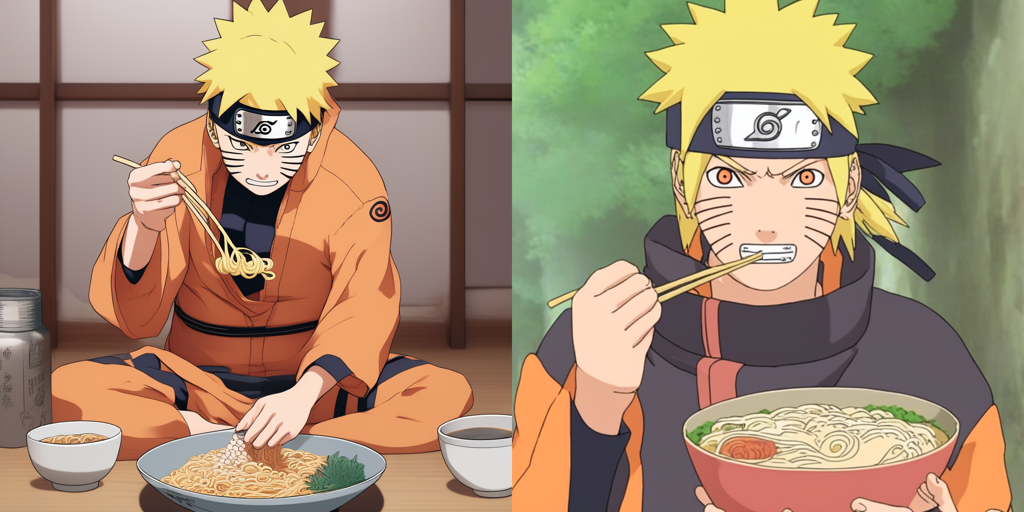


Processing: Bill Gates in Naruto style
...Generating Base Image


  0%|          | 0/30 [00:00<?, ?it/s]

...Injecting Adapters
...Generating Fine-Tuned Image


  0%|          | 0/30 [00:00<?, ?it/s]

--- Result for: 'Bill Gates in Naruto style' ---
Left: Base Model | Right: Fine-Tuned


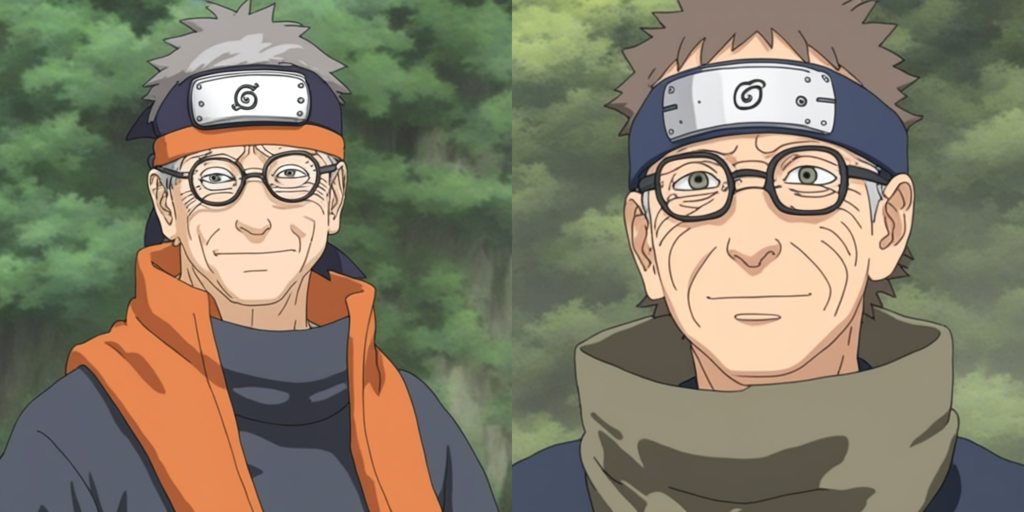


Processing: A boy with blue eyes in Naruto style
...Generating Base Image


  0%|          | 0/30 [00:00<?, ?it/s]

...Injecting Adapters
...Generating Fine-Tuned Image


  0%|          | 0/30 [00:00<?, ?it/s]

--- Result for: 'A boy with blue eyes in Naruto style' ---
Left: Base Model | Right: Fine-Tuned


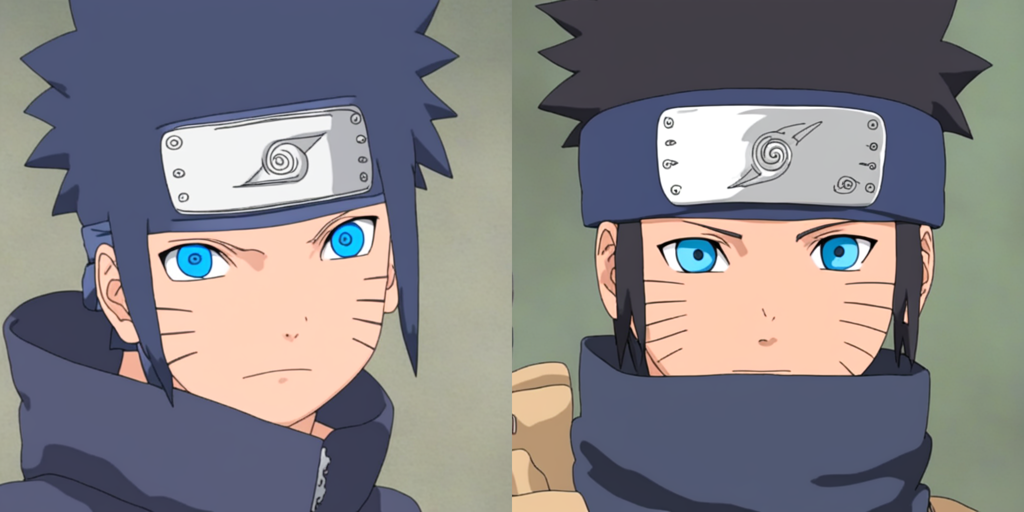

Done!


In [59]:
import torch
import gc
from diffusers import StableDiffusionXLPipeline, AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTokenizer, CLIPTextModel, CLIPTextModelWithProjection, BitsAndBytesConfig
from peft import PeftModel
from PIL import Image
from IPython.display import display


BASE_MODEL_ID = "/kaggle/working/sdxl-base-1.0"
LORA_WEIGHTS_PATH = "/kaggle/working/naruto_sdxl_lora"
PROMPTS = [
    "Naruto Uzumaki eating ramen",
    "Bill Gates in Naruto style",
    "A boy with blue eyes in Naruto style",
]

def flush():
    """Releases VRAM to prevent OOM."""
    torch.cuda.empty_cache()
    gc.collect()

def load_optimized_pipeline(base_model_id):
    print(f"Loading components to GPU...")
    
    # 1. Define 4-bit Config
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )


    vae = AutoencoderKL.from_pretrained(
        "madebyollin/sdxl-vae-fp16-fix", 
        torch_dtype=torch.float16
    ).to("cuda")

    text_encoder = CLIPTextModel.from_pretrained(
        base_model_id, subfolder="text_encoder", torch_dtype=torch.float16
    ).to("cuda")
    
    text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(
        base_model_id, subfolder="text_encoder_2", torch_dtype=torch.float16
    ).to("cuda")

    tokenizer = CLIPTokenizer.from_pretrained(base_model_id, subfolder="tokenizer")
    tokenizer_2 = CLIPTokenizer.from_pretrained(base_model_id, subfolder="tokenizer_2")


    print("Loading UNet in 4-bit...")
    unet = UNet2DConditionModel.from_pretrained(
        base_model_id,
        subfolder="unet",
        quantization_config=bnb_config,
        torch_dtype=torch.float16,
        device_map="auto"
    )

    #pipeline
    pipe = StableDiffusionXLPipeline(
        vae=vae,
        text_encoder=text_encoder,
        text_encoder_2=text_encoder_2,
        tokenizer=tokenizer,
        tokenizer_2=tokenizer_2,
        unet=unet,
        scheduler=DDPMScheduler.from_pretrained(base_model_id, subfolder="scheduler")
    )


    pipe.enable_vae_slicing()
    
    return pipe


pipe = load_optimized_pipeline(BASE_MODEL_ID)
generator = torch.Generator("cuda").manual_seed(42)

print("\n=== STARTING INFERENCE (Display Only) ===")

for prompt in PROMPTS:
    print(f"\nProcessing: {prompt}")
    
    #Base model
    print("...Generating Base Image")
    base_image = pipe(
        prompt, 
        num_inference_steps=30, 
        guidance_scale=7.5,
        generator=generator
    ).images[0]
    
    #QLoRA Injection
    print("...Injecting Adapters")
    try:
        original_unet = pipe.unet
        
        # Wrap UNet with PeftModel
        pipe.unet = PeftModel.from_pretrained(
            pipe.unet, 
            LORA_WEIGHTS_PATH,
            adapter_name="naruto_style"
        )
        
        print("...Generating Fine-Tuned Image")
        tuned_image = pipe(
            prompt, 
            num_inference_steps=30, 
            guidance_scale=7.5, 
            generator=generator
        ).images[0]


        # Create side-by-side comparison
        total_width = base_image.width + tuned_image.width
        comparison = Image.new('RGB', (total_width, base_image.height))
        comparison.paste(base_image, (0, 0))
        comparison.paste(tuned_image, (base_image.width, 0))
        
        # Resize for colab display area (optional, makes it fit better)
        display_img = comparison.resize((1024, 512))
        
        print(f"--- Result for: '{prompt}' ---")
        print("Left: Base Model | Right: Fine-Tuned")
        display(display_img)
        
        # Cleanup: Unwrap to reset for next prompt
        pipe.unet = original_unet 
        del tuned_image
        
    except Exception as e:
        print(f"Inference Failed: {e}")
    
    # Cleanup VRAM
    del base_image
    flush()

print("Done!")